# README
수정해야 하는 변수는 모두 hyper-param에서 args로 관리

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
# random seed를 적용하기 위함
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

## [C] 모델 생긴거 이쁘게 출력 (선택사항)

In [15]:
# !pip install pytorch-model-summary
# from pytorch_model_summary import summary
# !pip install transformers

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
import math

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# hyper-param
관리를 쉽게 하기 위해 hyper-param은 모두 args 객체로 관리   
그 밖에 환경에 따라 바꿔야 하는 변수도 모두 args로 관리   

In [17]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# random
args.seed = 42

# path
args.dataset_dir = "data_for_cpu"
# weight 저장용 폴더의 path(없으면 만드셈)
args.weight_dir = "model_weight"

# train
args.epoch = 50
args.batch_size = 32
args.lr = 1e-4

## random 통제 (시연 위함)   
https://dacon.io/en/forum/407713

In [18]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["PYTHONHASHSEED"] = str(args.seed)
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# 데이터셋 분할 (훈련 : 검증 : 평가 = 8 : 1 : 1)
train_dataset, val_dataset 모두 impact, non-imact 데이터가 균일하게 분포하게끔 코드를 변경함(train_test_split 함수에서 stratify option 이용)

In [19]:
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = labels
        if len(self.data_dir) != len(self.labels): raise RuntimeError("data_dir size and label size is different")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path, label = self.data_dir[idx], self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 열기 및 RGB로 변환

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
# 데이터 전처리 및 증강
transform = transforms.Compose([
    # [C] 학습의 효율성을 위해 dataset을 300x300으로 미리 변환함
    # transforms.Resize((224, 224)),
    # [C] 돌아가서나 뒤집히면 안되는 데이터
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root=args.dataset_dir, transform=transform)
X, y = [], []
for p, l in dataset.imgs:
    X.append(p)
    y.append(1 if l==0 else 0)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=args.seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=args.seed)

In [21]:
print(f"0_train_label : 1_train_label = {y_train.count(0)}: {y_train.count(1)}")
print(f"0_val_label : 1_val_label = {y_val.count(0)}: {y_val.count(1)}")
print(f"0_test_label : 1_test_label = {y_test.count(0)}: {y_test.count(1)}")

0_train_label : 1_train_label = 20: 16
0_val_label : 1_val_label = 2: 2
0_test_label : 1_test_label = 3: 2


In [22]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

# ResNet 모델 로드
1에 가까울 수록 impact data

In [23]:
# ResNet 모델 로드 (사전 학습된 가중치 사용 안 함)
# [C] 사용 하는게 좋음
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# [c] 마지막 레이어 수정 (클래스 수는 1로 가정, 확률 출력하게 할 거임. 1에 가까울 수록 impact data)
num_classes = 1
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, num_classes), nn.Sigmoid())

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

## 모델 구조 이쁘게 출력(선택사항)

In [24]:
# # show output shape and batch_size in table. In addition, also hierarchical summary version
# tmp = torch.zeros(args.batch_size, 3, 224, 224).to(device)
# summary(model, tmp, show_hierarchical=True, print_summary=True)

# 손실 함수 및 옵티마이저 설정

In [25]:
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=int(len(train_loader) * args.epoch * 0.1),
    num_training_steps=(len(train_loader) * args.epoch)
)

In [26]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum().item()
    return acc

In [27]:
cur_dir = args.weight_dir+f"/weight_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)
    print(f"모델의 weight를 저장하기 위한 디렉토리 생성: {cur_dir}")
else:
    print(f"디렉토리 이미 존재함: {cur_dir}")

모델의 weight를 저장하기 위한 디렉토리 생성: model_weight/weight_2024-06-20_17-59-40


# validation

In [28]:
# return validation loss
def validate():
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            # [C] label이 integer면 MSE 쓸 때 오류남
            images, labels = images.to(device), labels.to(device).float().view(-1,1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += binary_accuracy(outputs, labels)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
    return avg_val_loss, avg_val_acc

# train

In [29]:
# [C] 학습시간은  tqdm으로 대체(더 보기 편해)
def train():
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1,1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        running_acc += binary_accuracy(outputs, labels)

    avg_train_loss = running_loss / len(train_loader.dataset)
    avg_train_acc = running_acc / len(train_loader.dataset)

    return avg_train_loss, avg_train_acc

# 결과

In [30]:
list_epoch = []
list_train_loss = []
list_train_acc = []
list_val_loss = []
list_val_acc = []
list_lr = []

In [31]:
# [C] 학습시간은  tqdm으로 대체(더 보기 편해)
for epoch in tqdm(range(1, args.epoch+1)):
    print(f"\n epoch: {epoch}")
    avg_train_loss, avg_train_acc = train()
    avg_val_loss, avg_val_acc = validate()

    list_epoch.append(epoch)
    list_train_loss.append(avg_train_loss)
    list_train_acc.append(avg_train_acc)
    
    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_acc)
    list_lr.append(scheduler.get_last_lr()[0])

    # 학습된 모델 가중치 저장
    print(f"train_loss: {avg_train_loss}, train_acc: {avg_train_acc}")
    print(f"val_loss: {avg_val_loss}, val_acc: {avg_val_acc}")
    torch.save(model.state_dict(), cur_dir+f"/{epoch}_{avg_train_loss}.pth")

  0%|          | 0/50 [00:00<?, ?it/s]


 epoch: 1


  2%|▏         | 1/50 [00:09<07:50,  9.59s/it]

train_loss: 0.6846277581320869, train_acc: 0.6666666666666666
val_loss: 0.6176949143409729, val_acc: 0.75

 epoch: 2


  4%|▍         | 2/50 [00:16<06:36,  8.27s/it]

train_loss: 0.6251029703352187, train_acc: 0.7222222222222222
val_loss: 0.557954728603363, val_acc: 1.0

 epoch: 3


  6%|▌         | 3/50 [00:24<06:10,  7.88s/it]

train_loss: 0.4016454451613956, train_acc: 0.9722222222222222
val_loss: 0.45224466919898987, val_acc: 1.0

 epoch: 4


  8%|▊         | 4/50 [00:31<05:47,  7.56s/it]

train_loss: 0.2942833701769511, train_acc: 0.9166666666666666
val_loss: 0.3479280173778534, val_acc: 1.0

 epoch: 5


 10%|█         | 5/50 [00:41<06:19,  8.43s/it]

train_loss: 0.13855158620410496, train_acc: 0.9722222222222222
val_loss: 0.23512019217014313, val_acc: 1.0

 epoch: 6


 12%|█▏        | 6/50 [00:50<06:14,  8.50s/it]

train_loss: 0.07674022184477912, train_acc: 1.0
val_loss: 0.12035670876502991, val_acc: 1.0

 epoch: 7


 14%|█▍        | 7/50 [00:57<05:48,  8.10s/it]

train_loss: 0.04648109277089437, train_acc: 1.0
val_loss: 0.07468874752521515, val_acc: 1.0

 epoch: 8


 16%|█▌        | 8/50 [01:07<06:06,  8.72s/it]

train_loss: 0.03573287857903375, train_acc: 1.0
val_loss: 0.047390166670084, val_acc: 1.0

 epoch: 9


 18%|█▊        | 9/50 [01:14<05:34,  8.17s/it]

train_loss: 0.017038436296085518, train_acc: 1.0
val_loss: 0.037163518369197845, val_acc: 1.0

 epoch: 10


 20%|██        | 10/50 [01:22<05:33,  8.33s/it]

train_loss: 0.020117503073480394, train_acc: 1.0
val_loss: 0.030309485271573067, val_acc: 1.0

 epoch: 11


 22%|██▏       | 11/50 [01:35<06:13,  9.57s/it]

train_loss: 0.009912485049830543, train_acc: 1.0
val_loss: 0.025434892624616623, val_acc: 1.0

 epoch: 12


 24%|██▍       | 12/50 [01:45<06:09,  9.72s/it]

train_loss: 0.013050249881214566, train_acc: 1.0
val_loss: 0.02297035977244377, val_acc: 1.0

 epoch: 13


 26%|██▌       | 13/50 [01:59<06:46, 10.99s/it]

train_loss: 0.011448471496502558, train_acc: 1.0
val_loss: 0.02278827875852585, val_acc: 1.0

 epoch: 14


 28%|██▊       | 14/50 [02:08<06:19, 10.53s/it]

train_loss: 0.007739918927351634, train_acc: 1.0
val_loss: 0.01787675730884075, val_acc: 1.0

 epoch: 15


 30%|███       | 15/50 [02:19<06:07, 10.51s/it]

train_loss: 0.006367922087924348, train_acc: 1.0
val_loss: 0.013538709841668606, val_acc: 1.0

 epoch: 16


 32%|███▏      | 16/50 [02:27<05:32,  9.77s/it]

train_loss: 0.007093596582611402, train_acc: 1.0
val_loss: 0.011261595413088799, val_acc: 1.0

 epoch: 17


 34%|███▍      | 17/50 [02:34<05:00,  9.11s/it]

train_loss: 0.0048041570828192765, train_acc: 1.0
val_loss: 0.00935350265353918, val_acc: 1.0

 epoch: 18


 36%|███▌      | 18/50 [02:44<04:51,  9.11s/it]

train_loss: 0.003963498605622185, train_acc: 1.0
val_loss: 0.007238199934363365, val_acc: 1.0

 epoch: 19


 38%|███▊      | 19/50 [02:51<04:31,  8.74s/it]

train_loss: 0.007554310063521068, train_acc: 1.0
val_loss: 0.0052445316687226295, val_acc: 1.0

 epoch: 20


 40%|████      | 20/50 [02:59<04:13,  8.44s/it]

train_loss: 0.0030655338066733545, train_acc: 1.0
val_loss: 0.005164820700883865, val_acc: 1.0

 epoch: 21


 42%|████▏     | 21/50 [03:07<04:02,  8.37s/it]

train_loss: 0.004364529210660193, train_acc: 1.0
val_loss: 0.0059607382863759995, val_acc: 1.0

 epoch: 22


 44%|████▍     | 22/50 [03:16<03:57,  8.47s/it]

train_loss: 0.0023080630279663536, train_acc: 1.0
val_loss: 0.005491503980010748, val_acc: 1.0

 epoch: 23


 46%|████▌     | 23/50 [03:24<03:44,  8.33s/it]

train_loss: 0.0020181277068331838, train_acc: 1.0
val_loss: 0.0052546970546245575, val_acc: 1.0

 epoch: 24


 48%|████▊     | 24/50 [03:32<03:29,  8.08s/it]

train_loss: 0.0019327735968141092, train_acc: 1.0
val_loss: 0.005678429268300533, val_acc: 1.0

 epoch: 25


 50%|█████     | 25/50 [03:40<03:23,  8.16s/it]

train_loss: 0.0018099996183688443, train_acc: 1.0
val_loss: 0.006021745968610048, val_acc: 1.0

 epoch: 26


 52%|█████▏    | 26/50 [03:47<03:11,  7.97s/it]

train_loss: 0.0026852544397115707, train_acc: 1.0
val_loss: 0.0070584057830274105, val_acc: 1.0

 epoch: 27


 54%|█████▍    | 27/50 [03:56<03:06,  8.12s/it]

train_loss: 0.0035814380066262353, train_acc: 1.0
val_loss: 0.008006660267710686, val_acc: 1.0

 epoch: 28


 56%|█████▌    | 28/50 [04:03<02:54,  7.91s/it]

train_loss: 0.0017147076173892452, train_acc: 1.0
val_loss: 0.007228923495858908, val_acc: 1.0

 epoch: 29


 58%|█████▊    | 29/50 [04:11<02:45,  7.86s/it]

train_loss: 0.0016310163902946645, train_acc: 1.0
val_loss: 0.007121640257537365, val_acc: 1.0

 epoch: 30


 60%|██████    | 30/50 [04:18<02:33,  7.69s/it]

train_loss: 0.002484133674038781, train_acc: 1.0
val_loss: 0.007652654312551022, val_acc: 1.0

 epoch: 31


 62%|██████▏   | 31/50 [04:26<02:27,  7.78s/it]

train_loss: 0.003237578293515576, train_acc: 1.0
val_loss: 0.009343843907117844, val_acc: 1.0

 epoch: 32


 64%|██████▍   | 32/50 [04:34<02:21,  7.88s/it]

train_loss: 0.0016113205023834275, train_acc: 1.0
val_loss: 0.00814022310078144, val_acc: 1.0

 epoch: 33


 66%|██████▌   | 33/50 [04:42<02:12,  7.79s/it]

train_loss: 0.09898246897177564, train_acc: 0.9444444444444444
val_loss: 0.00859867874532938, val_acc: 1.0

 epoch: 34


 68%|██████▊   | 34/50 [04:49<02:02,  7.66s/it]

train_loss: 0.001520761224027309, train_acc: 1.0
val_loss: 0.0059388610534369946, val_acc: 1.0

 epoch: 35


 70%|███████   | 35/50 [04:57<01:54,  7.63s/it]

train_loss: 0.0019014451859725846, train_acc: 1.0
val_loss: 0.005221129860728979, val_acc: 1.0

 epoch: 36


 72%|███████▏  | 36/50 [05:05<01:49,  7.81s/it]

train_loss: 0.004229158473511537, train_acc: 1.0
val_loss: 0.005406358279287815, val_acc: 1.0

 epoch: 37


 74%|███████▍  | 37/50 [05:13<01:42,  7.89s/it]

train_loss: 0.003964691526359982, train_acc: 1.0
val_loss: 0.005123178940266371, val_acc: 1.0

 epoch: 38


 76%|███████▌  | 38/50 [05:21<01:33,  7.83s/it]

train_loss: 0.0042563627163569135, train_acc: 1.0
val_loss: 0.0064973533153533936, val_acc: 1.0

 epoch: 39


 78%|███████▊  | 39/50 [05:28<01:24,  7.71s/it]

train_loss: 0.0035794901066563195, train_acc: 1.0
val_loss: 0.0058628711849451065, val_acc: 1.0

 epoch: 40


 80%|████████  | 40/50 [05:37<01:20,  8.05s/it]

train_loss: 0.008735526870522235, train_acc: 1.0
val_loss: 0.005157775245606899, val_acc: 1.0

 epoch: 41


 82%|████████▏ | 41/50 [05:45<01:11,  7.97s/it]

train_loss: 0.0036221068197240434, train_acc: 1.0
val_loss: 0.0047369347885251045, val_acc: 1.0

 epoch: 42


 84%|████████▍ | 42/50 [05:52<01:02,  7.81s/it]

train_loss: 0.010650495067238808, train_acc: 1.0
val_loss: 0.004946773871779442, val_acc: 1.0

 epoch: 43


 86%|████████▌ | 43/50 [06:01<00:55,  7.96s/it]

train_loss: 0.003672844070630769, train_acc: 1.0
val_loss: 0.0053514400497078896, val_acc: 1.0

 epoch: 44


 88%|████████▊ | 44/50 [06:09<00:48,  8.15s/it]

train_loss: 0.003955111424956057, train_acc: 1.0
val_loss: 0.0064697908237576485, val_acc: 1.0

 epoch: 45


 90%|█████████ | 45/50 [06:18<00:40,  8.19s/it]

train_loss: 0.011584473980797661, train_acc: 1.0
val_loss: 0.004511138424277306, val_acc: 1.0

 epoch: 46


 92%|█████████▏| 46/50 [06:25<00:32,  8.06s/it]

train_loss: 0.0033541443343791696, train_acc: 1.0
val_loss: 0.004241774324327707, val_acc: 1.0

 epoch: 47


 94%|█████████▍| 47/50 [06:33<00:23,  7.82s/it]

train_loss: 0.0028745774697098467, train_acc: 1.0
val_loss: 0.004838606342673302, val_acc: 1.0

 epoch: 48


 96%|█████████▌| 48/50 [06:41<00:15,  7.92s/it]

train_loss: 0.008115840454896292, train_acc: 1.0
val_loss: 0.00479508750140667, val_acc: 1.0

 epoch: 49


 98%|█████████▊| 49/50 [06:49<00:07,  7.94s/it]

train_loss: 0.09267764145301448, train_acc: 0.9722222222222222
val_loss: 0.004649910144507885, val_acc: 1.0

 epoch: 50


100%|██████████| 50/50 [06:56<00:00,  8.33s/it]

train_loss: 0.008760636879338158, train_acc: 1.0
val_loss: 0.004905572161078453, val_acc: 1.0


# 결과 그래프

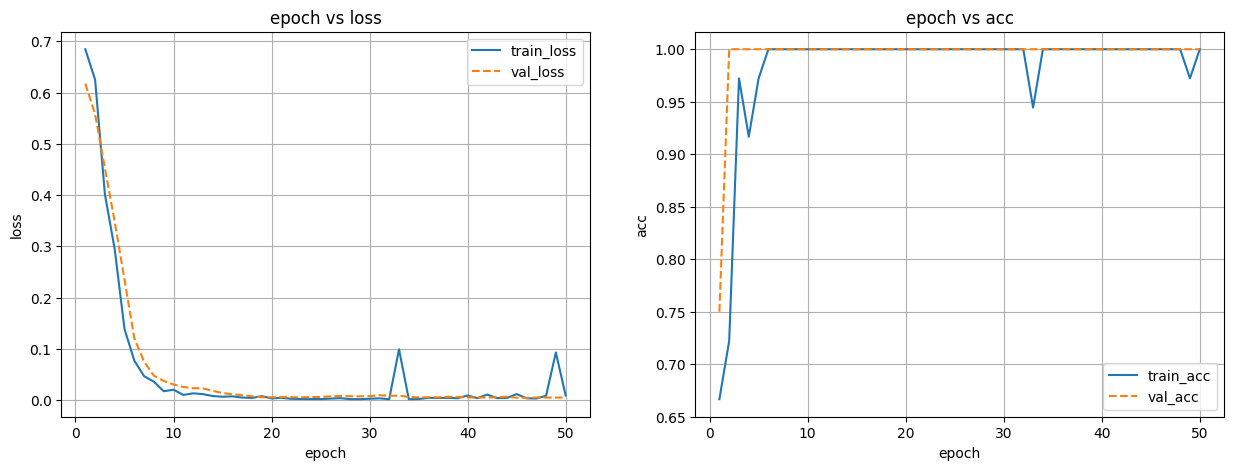

In [32]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
# ax1.set_ylim([1000, 2000])
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== accuracy Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_train_acc, label='train_acc')
ax2.plot(list_epoch, list_val_acc, '--', label='val_acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs acc')

plt.savefig(cur_dir+"matrix.png", dpi=400)

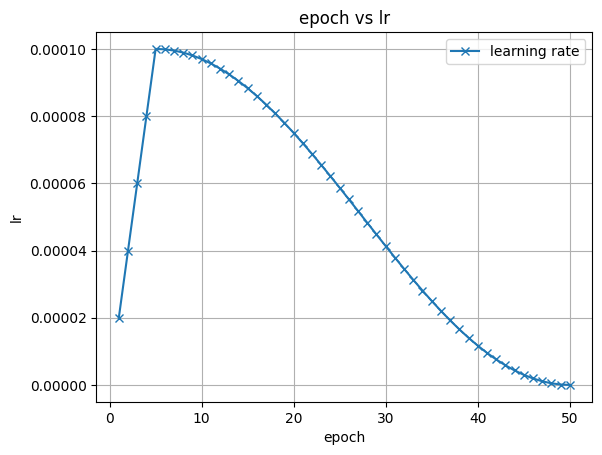

In [34]:
plt.plot(list_epoch, list_lr, marker='x', label='learning rate')
plt.xlabel('epoch')
plt.ylabel('lr')
plt.grid()
plt.legend()
plt.title('epoch vs lr')
plt.legend()
plt.savefig(cur_dir+"lr.png", dpi=400)

# Eval

In [35]:
# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device).view(-1,1)

        outputs = model(images)
        total += labels.size(0)
        correct += binary_accuracy(outputs, labels)

accuracy = (correct / total)*100
print(accuracy)

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

100.0
